In [1]:
!pip install -q flwr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 598.1/598.1 kB 14.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.4/242.4 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 2.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.8 which is incompatible.
google-spark-connect 0.5.2 requires google-api-core>=2.19.1, but you have google-api-core 1.34.1 which is incompatible.
google-cloud-bigtable 2.30.0 requires google-api-core[grpc]<3.0.0,>=2.16.0, but you have google-api-core 1.34.1 whic

In [2]:
!pip install -U flwr

In [3]:
# --- Imports ---
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import pandas as pd
import gc
import time
import flwr as fl
from flwr.client import NumPyClient
from flwr.common import Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedProx

# --- Load and prepare data ---
data = np.load("/kaggle/input/daicwoz-balanced/dataset_balanced.npz")
test_ids = np.load("/kaggle/input/daicwoz-balanced/test_ids (1).npy")

X_audio_test = data["X_audio_test"]
X_text_test = data["X_text_test"]
y_test = data["y_test"]

X_audio_dev = data["X_audio_dev"]
X_text_dev = data["X_text_dev"]
y_dev = data["y_dev"]

X_audio_train = data["X_audio_train"]
X_text_train = data["X_text_train"]
y_train = data["y_train"]

y_train = y_train.reshape(-1, 1)
y_dev = y_dev.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# --- Parameters ---
NUM_CLIENTS = 10
input_shape_audio = (378, 60)
input_shape_text = (378, 9)

# --- Build model ---
def build_model():
    input_audio = layers.Input(shape=input_shape_audio, name='mfcc_input')
    x_audio = layers.LSTM(60, return_sequences=True, recurrent_dropout=0.002,
                          bias_regularizer=regularizers.l1_l2(1e-4, 1e-4))(input_audio)
    x_audio = layers.BatchNormalization()(x_audio)
    x_audio = layers.Dropout(2e-4)(x_audio)
    x_audio = layers.LSTM(40, return_sequences=True, recurrent_dropout=0.002,
                          bias_regularizer=regularizers.l1_l2(1e-4, 1e-4))(x_audio)
    x_audio = layers.BatchNormalization()(x_audio)
    x_audio = layers.Dropout(2e-4)(x_audio)
    x_audio = layers.LSTM(20, return_sequences=False, recurrent_dropout=0.002,
                          bias_regularizer=regularizers.l1_l2(1e-4, 1e-4))(x_audio)
    x_audio = layers.BatchNormalization()(x_audio)
    x_audio = layers.Dropout(2e-4)(x_audio)

    input_text = layers.Input(shape=input_shape_text, name='text_input')
    x_text = layers.Flatten()(input_text)

    x = layers.Concatenate()([x_audio, x_text])
    x = layers.Reshape((1, -1))(x)
    x = layers.LSTM(20, return_sequences=False, recurrent_dropout=0.002)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(2e-4)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(15, activation='tanh')(x)
    x = layers.Dense(10, activation='tanh')(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    return models.Model(inputs=[input_audio, input_text], outputs=output)

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def compile_model():
    model = build_model()
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(1e-5),
        loss=rmse,
        metrics=['accuracy', 'mae', rmse]
    )
    return model

def split_data(num_clients):
    size = len(y_train) // num_clients
    return [
        (X_audio_train[i * size : (i + 1) * size if i != num_clients - 1 else None],
         X_text_train[i * size : (i + 1) * size if i != num_clients - 1 else None],
         y_train[i * size : (i + 1) * size if i != num_clients - 1 else None])
        for i in range(num_clients)
    ]

client_datasets = split_data(NUM_CLIENTS)

def get_model_size(weights):
    return sum([w.nbytes for w in weights])

# --- Flower Client ---
class DepressionClient(NumPyClient):
    def __init__(self, model, X_audio_c, X_text_c, y_c):
        self.model = model
        self.X_audio_train = X_audio_c
        self.X_text_train = X_text_c
        self.y_train = y_c
        self.X_audio_test = X_audio_dev
        self.X_text_test = X_text_dev
        self.y_test = y_dev

    def get_parameters(self, config=None):
        return self.model.get_weights()

    def set_parameters(self, parameters):
        self.model.set_weights(parameters)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        self.model.fit(
            [self.X_audio_train, self.X_text_train],
            self.y_train,
            batch_size=32,
            epochs=2,
            verbose=0,
            shuffle=True,
        )
        return self.get_parameters(), len(self.y_train), {}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        loss, acc, mae, rmse_val = self.model.evaluate(
            [self.X_audio_test, self.X_text_test], self.y_test, verbose=0
        )
        return float(loss), len(self.y_test), {
            "accuracy": float(acc),
            "mae": float(mae),
            "rmse": float(rmse_val)
        }

# --- Simulation loop over multiple proximal_mu ---
results = {}
proximal_mu_values = [0.0, 0.01, 0.1, 0.5]

for proximal_mu in proximal_mu_values:
    print(f"\n🚀 Testing FedProx with proximal_mu = {proximal_mu}")

    global_metrics = {
        "accuracy": [],
        "mae": [],
        "rmse": [],
        "f1_score": [],
        "precision": [],
        "recall": [],
        "comm_bytes": [],
        "round_time_sec": []
    }

    # --- Client App ---
    def client_fn(context: Context):
        partition_id = int(context.node_config.get("partition-id", 0))
        model = compile_model()
        X_audio_c, X_text_c, y_c = client_datasets[partition_id]
        return DepressionClient(model, X_audio_c, X_text_c, y_c).to_client()

    client_app = fl.client.ClientApp(client_fn=client_fn)

    # --- Server App ---
    def server_fn(context: Context) -> ServerAppComponents:
        model = compile_model()

        def evaluate_fn(server_round, parameters, _config):
            start = time.time()

            model.set_weights(parameters)
            y_pred = model.predict([X_audio_test, X_text_test], verbose=0)
            y_pred_labels = (y_pred > 0.5).astype(int)

            acc = accuracy_score(y_test, y_pred_labels)
            f1 = f1_score(y_test, y_pred_labels)
            prec = precision_score(y_test, y_pred_labels)
            rec = recall_score(y_test, y_pred_labels)
            mae_val = np.mean(np.abs(y_test - y_pred))
            rmse_val = np.sqrt(np.mean((y_test - y_pred) ** 2))

            bytes_per_round = get_model_size(parameters) * NUM_CLIENTS * 2
            round_time = time.time() - start

            global_metrics["accuracy"].append(acc)
            global_metrics["mae"].append(mae_val)
            global_metrics["rmse"].append(rmse_val)
            global_metrics["f1_score"].append(f1)
            global_metrics["precision"].append(prec)
            global_metrics["recall"].append(rec)
            global_metrics["comm_bytes"].append(bytes_per_round)
            global_metrics["round_time_sec"].append(round_time)

            print(f"📊 Round {server_round} — Acc: {acc:.4f}, F1: {f1:.4f}, MAE: {mae_val:.4f}, RMSE: {rmse_val:.4f}")

            tf.keras.backend.clear_session()
            gc.collect()

            return float(rmse_val), {
                "accuracy": float(acc),
                "f1_score": float(f1),
                "precision": float(prec),
                "recall": float(rec),
                "mae": float(mae_val),
                "rmse": float(rmse_val),
                "comm_bytes": bytes_per_round,
                "round_time_sec": round_time
            }

        strategy = FedProx(
            fraction_fit=0.8,
            fraction_evaluate=0.5,
            min_fit_clients=NUM_CLIENTS,
            min_evaluate_clients=5,
            min_available_clients=NUM_CLIENTS,
            evaluate_fn=evaluate_fn,
            proximal_mu=proximal_mu,
        )

        return ServerAppComponents(strategy=strategy, config=ServerConfig(num_rounds=5))

    server_app = ServerApp(server_fn=server_fn)

    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}
    fl.simulation.run_simulation(
        server_app=server_app,
        client_app=client_app,
        num_supernodes=NUM_CLIENTS,
        backend_config=backend_config,
    )

    results[proximal_mu] = global_metrics


2025-07-04 17:20:50.217156: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751649650.509017      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751649650.595803      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



🚀 Testing FedProx with proximal_mu = 0.0


2025-07-04 17:21:30.201118: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=440) 2025-07-04 17:21:40.619249: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=440) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=440) E0000 00:00:1751649700.679323     440 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=440) E0000 00:00:1751649700.696157     440 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plug

📊 Round 0 — Acc: 0.4885, F1: 0.6475, MAE: 0.5007, RMSE: 0.5018


INFO :      initial parameters (loss, other metrics): 0.5018092393875122, {'accuracy': 0.4885057471264368, 'f1_score': 0.6475247524752474, 'precision': 0.49395770392749244, 'recall': 0.9396551724137931, 'mae': 0.5007213354110718, 'rmse': 0.5018092393875122, 'comm_bytes': 26125280, 'round_time_sec': 9.803846597671509}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=441) 2025-07-04 17:22:03.496748: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
(ClientAppActor pid=440) 2025-07-04 17:22:03.567006: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 1 — Acc: 0.5129, F1: 0.5356, MAE: 0.5008, RMSE: 0.5020


INFO :      fit progress: (1, 0.5020433068275452, {'accuracy': 0.5129310344827587, 'f1_score': 0.5356164383561645, 'precision': 0.5117801047120419, 'recall': 0.5617816091954023, 'mae': 0.5008481740951538, 'rmse': 0.5020433068275452, 'comm_bytes': 26125280, 'round_time_sec': 7.239901781082153}, 414.1811926959999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 2 — Acc: 0.5072, F1: 0.5121, MAE: 0.5009, RMSE: 0.5025


INFO :      fit progress: (2, 0.502548336982727, {'accuracy': 0.507183908045977, 'f1_score': 0.5120910384068278, 'precision': 0.5070422535211268, 'recall': 0.5172413793103449, 'mae': 0.5009211897850037, 'rmse': 0.502548336982727, 'comm_bytes': 26125280, 'round_time_sec': 7.363292932510376}, 889.566905311)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(raylet) Spilled 3012 MiB, 3 objects, write throughput 323 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(ClientAppActor pid=435) 2025-07-04 17:22:03.580117: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(raylet) Spilled 6024 MiB, 6 objects, write throughput 322 MiB/s.
INFO :      aggregate_fit: received 10 results and 0 failures

📊 Round 3 — Acc: 0.5000, F1: 0.4905, MAE: 0.5009, RMSE: 0.5034


INFO :      fit progress: (3, 0.5033738017082214, {'accuracy': 0.5, 'f1_score': 0.4904831625183016, 'precision': 0.5, 'recall': 0.4813218390804598, 'mae': 0.5009273290634155, 'rmse': 0.5033738017082214, 'comm_bytes': 26125280, 'round_time_sec': 7.684941291809082}, 1377.6844709309999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(raylet) Spilled 10041 MiB, 10 objects, write throughput 284 MiB/s.
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 4 — Acc: 0.5000, F1: 0.4814, MAE: 0.5008, RMSE: 0.5045


INFO :      fit progress: (4, 0.5045215487480164, {'accuracy': 0.5, 'f1_score': 0.48137108792846495, 'precision': 0.5, 'recall': 0.4640804597701149, 'mae': 0.5008105039596558, 'rmse': 0.5045215487480164, 'comm_bytes': 26125280, 'round_time_sec': 8.088584423065186}, 1878.108092123)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 5 — Acc: 0.4986, F1: 0.4744, MAE: 0.5006, RMSE: 0.5059


INFO :      fit progress: (5, 0.5059413313865662, {'accuracy': 0.4985632183908046, 'f1_score': 0.4743975903614458, 'precision': 0.49841772151898733, 'recall': 0.4525862068965517, 'mae': 0.5005508065223694, 'rmse': 0.5059413313865662, 'comm_bytes': 26125280, 'round_time_sec': 7.860795259475708}, 2388.076824676)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(raylet) Spilled 19078 MiB, 19 objects, write throughput 304 MiB/s.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 2444.34s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.5251554846763611
INFO :      		round 2: 0.5255427956581116
INFO :      		round 3: 0.5261531472206116
INFO :      		round 4: 0.527259886264801
INFO :      		round 5: 0.5288714170455933
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.5018092393875122
INFO :      		round 1: 0.5020433068275452
INFO :      		round 2: 


🚀 Testing FedProx with proximal_mu = 0.01


INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=12967) 2025-07-04 18:03:00.034220: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=12967) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=12967) E0000 00:00:1751652180.172828   12967 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=12967) E0000 00:00:1751652180.220149   12967 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=12963) 2025-07-04 18:03:16.716607: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed

📊 Round 0 — Acc: 0.5007, F1: 0.5811, MAE: 0.4995, RMSE: 0.5006


INFO :      initial parameters (loss, other metrics): 0.5005730390548706, {'accuracy': 0.5007183908045977, 'f1_score': 0.5810729355033152, 'precision': 0.5005192107995846, 'recall': 0.6925287356321839, 'mae': 0.49953988194465637, 'rmse': 0.5005730390548706, 'comm_bytes': 26125280, 'round_time_sec': 10.114345073699951}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=12967) 2025-07-04 18:03:30.018213: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
(ClientAppActor pid=12965) 2025-07-04 18:03:30.640035: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
(raylet) Spilled 3013 MiB, 4 objects, write throughput 304 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(ClientAppActor pid=12966) 2025-07-04 18

📊 Round 1 — Acc: 0.5201, F1: 0.4854, MAE: 0.4996, RMSE: 0.5007


INFO :      fit progress: (1, 0.5007464289665222, {'accuracy': 0.5201149425287356, 'f1_score': 0.48536209553158705, 'precision': 0.5232558139534884, 'recall': 0.4525862068965517, 'mae': 0.4995935261249542, 'rmse': 0.5007464289665222, 'comm_bytes': 26125280, 'round_time_sec': 8.72206449508667}, 463.9439594999999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(raylet) Spilled 5024 MiB, 8 objects, write throughput 269 MiB/s.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(raylet) Spilled 9041 MiB, 12 objects, write throughput 339 MiB/s.
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 2 — Acc: 0.5165, F1: 0.4443, MAE: 0.4997, RMSE: 0.5014


INFO :      fit progress: (2, 0.5014022588729858, {'accuracy': 0.5165229885057471, 'f1_score': 0.444260941370768, 'precision': 0.5223300970873787, 'recall': 0.3864942528735632, 'mae': 0.499734103679657, 'rmse': 0.5014022588729858, 'comm_bytes': 26125280, 'round_time_sec': 11.985817909240723}, 1016.1209141819995)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 3 — Acc: 0.5065, F1: 0.4212, MAE: 0.5000, RMSE: 0.5026


INFO :      fit progress: (3, 0.5025880932807922, {'accuracy': 0.5064655172413793, 'f1_score': 0.4212299915754002, 'precision': 0.5091649694501018, 'recall': 0.35919540229885055, 'mae': 0.5000036954879761, 'rmse': 0.5025880932807922, 'comm_bytes': 26125280, 'round_time_sec': 8.215741634368896}, 1575.7846238779998)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(raylet) Spilled 17076 MiB, 22 objects, write throughput 244 MiB/s.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 4 — Acc: 0.5057, F1: 0.4179, MAE: 0.5004, RMSE: 0.5043


INFO :      fit progress: (4, 0.5042703747749329, {'accuracy': 0.5057471264367817, 'f1_score': 0.4179357021996616, 'precision': 0.5082304526748971, 'recall': 0.35488505747126436, 'mae': 0.5003725290298462, 'rmse': 0.5042703747749329, 'comm_bytes': 26125280, 'round_time_sec': 8.007107257843018}, 2151.310485826)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(raylet) Spilled 33150 MiB, 44 objects, write throughput 254 MiB/s.
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 5 — Acc: 0.5079, F1: 0.4219, MAE: 0.5009, RMSE: 0.5065


INFO :      fit progress: (5, 0.5065184831619263, {'accuracy': 0.5079022988505747, 'f1_score': 0.42194092827004215, 'precision': 0.5112474437627812, 'recall': 0.35919540229885055, 'mae': 0.5008968710899353, 'rmse': 0.5065184831619263, 'comm_bytes': 26125280, 'round_time_sec': 8.166226625442505}, 2764.8958320959996)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 2823.18s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.5255736708641052
INFO :      		round 2: 0.5260410308837891
INFO :      		round 3: 0.5267287492752075
INFO :      		round 4: 0.5278099179267883
INFO :      		round 5: 0.5293513536453247
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.5005730390548706
INFO :      		round 1: 0.5007464289665222
INFO :      		round 2: 0.5014022588729858
INFO :      		round 3: 0.5025880932807922
I


🚀 Testing FedProx with proximal_mu = 0.1


INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=25335) 2025-07-04 18:50:46.489070: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=25335) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=25335) E0000 00:00:1751655046.559469   25335 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=25335) E0000 00:00:1751655046.579782   25335 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=25334) 2025-07-04 18:50:57.194326: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed

📊 Round 0 — Acc: 0.4993, F1: 0.5229, MAE: 0.4997, RMSE: 0.5006


INFO :      initial parameters (loss, other metrics): 0.5005559325218201, {'accuracy': 0.4992816091954023, 'f1_score': 0.5229295003422314, 'precision': 0.4993464052287582, 'recall': 0.5488505747126436, 'mae': 0.49965035915374756, 'rmse': 0.5005559325218201, 'comm_bytes': 26125280, 'round_time_sec': 10.36845064163208}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=25335) 2025-07-04 18:51:11.804536: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
(ClientAppActor pid=25326) 2025-07-04 18:51:11.791871: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 1 — Acc: 0.5043, F1: 0.5531, MAE: 0.4997, RMSE: 0.5010


INFO :      fit progress: (1, 0.5009588599205017, {'accuracy': 0.5043103448275862, 'f1_score': 0.5531088082901554, 'precision': 0.5035377358490566, 'recall': 0.6135057471264368, 'mae': 0.4997170567512512, 'rmse': 0.5009588599205017, 'comm_bytes': 26125280, 'round_time_sec': 7.715959072113037}, 464.09055135999915)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 2 — Acc: 0.5359, F1: 0.4857, MAE: 0.4995, RMSE: 0.5016


INFO :      fit progress: (2, 0.5015614032745361, {'accuracy': 0.5359195402298851, 'f1_score': 0.4856687898089172, 'precision': 0.5446428571428571, 'recall': 0.4382183908045977, 'mae': 0.499460905790329, 'rmse': 0.5015614032745361, 'comm_bytes': 26125280, 'round_time_sec': 7.725133180618286}, 972.2476866459992)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(raylet) Spilled 3012 MiB, 3 objects, write throughput 249 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(ClientAppActor pid=25325) 2025-07-04 18:51:11.888524: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(raylet) Spilled 6024 MiB, 6 objects, write throughput 309 MiB/s.
INFO :      aggregate_fit: received 10 results and 0 

📊 Round 3 — Acc: 0.5287, F1: 0.4744, MAE: 0.4986, RMSE: 0.5020


INFO :      fit progress: (3, 0.5020151138305664, {'accuracy': 0.5287356321839081, 'f1_score': 0.4743589743589744, 'precision': 0.5362318840579711, 'recall': 0.42528735632183906, 'mae': 0.4985862672328949, 'rmse': 0.5020151138305664, 'comm_bytes': 26125280, 'round_time_sec': 8.408141613006592}, 1498.6642094689987)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(raylet) Spilled 9037 MiB, 9 objects, write throughput 259 MiB/s.
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 4 — Acc: 0.5287, F1: 0.4658, MAE: 0.4969, RMSE: 0.5022


INFO :      fit progress: (4, 0.5022401809692383, {'accuracy': 0.5287356321839081, 'f1_score': 0.4657980456026059, 'precision': 0.5375939849624061, 'recall': 0.4109195402298851, 'mae': 0.4969313144683838, 'rmse': 0.5022401809692383, 'comm_bytes': 26125280, 'round_time_sec': 8.46314811706543}, 2049.5979902299996)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 5 — Acc: 0.5338, F1: 0.4711, MAE: 0.4946, RMSE: 0.5024


INFO :      fit progress: (5, 0.5024455189704895, {'accuracy': 0.5337643678160919, 'f1_score': 0.4710676446617767, 'precision': 0.544256120527307, 'recall': 0.41522988505747127, 'mae': 0.4945981204509735, 'rmse': 0.5024455189704895, 'comm_bytes': 26125280, 'round_time_sec': 8.638855695724487}, 2574.24219052)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(raylet) Spilled 18074 MiB, 18 objects, write throughput 275 MiB/s.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 2632.07s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.5236868262290955
INFO :      		round 2: 0.5238152146339417
INFO :      		round 3: 0.5237389802932739
INFO :      		round 4: 0.5235117077827454
INFO :      		round 5: 0.5236076712608337
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.5005559325218201
INFO :      		round 1: 0.5009588599205017
INFO :      		round 2: 0


🚀 Testing FedProx with proximal_mu = 0.5


INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=37713) 2025-07-04 19:35:14.740740: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=37713) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=37713) E0000 00:00:1751657714.802162   37713 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=37713) E0000 00:00:1751657714.821072   37713 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=37715) 2025-07-04 19:35:24.909182: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed

📊 Round 0 — Acc: 0.5115, F1: 0.4138, MAE: 0.4998, RMSE: 0.5004


INFO :      initial parameters (loss, other metrics): 0.5003597736358643, {'accuracy': 0.5114942528735632, 'f1_score': 0.41379310344827586, 'precision': 0.5172413793103449, 'recall': 0.3448275862068966, 'mae': 0.49980759620666504, 'rmse': 0.5003597736358643, 'comm_bytes': 26125280, 'round_time_sec': 9.97660207748413}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=37713) 2025-07-04 19:35:38.751335: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
(ClientAppActor pid=37714) 2025-07-04 19:35:38.723999: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 1 — Acc: 0.5014, F1: 0.4236, MAE: 0.5000, RMSE: 0.5010


INFO :      fit progress: (1, 0.5010014176368713, {'accuracy': 0.5014367816091954, 'f1_score': 0.4235880398671096, 'precision': 0.5019685039370079, 'recall': 0.36637931034482757, 'mae': 0.49997469782829285, 'rmse': 0.5010014176368713, 'comm_bytes': 26125280, 'round_time_sec': 7.285984516143799}, 425.638626001999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(raylet) Spilled 3012 MiB, 3 objects, write throughput 230 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(ClientAppActor pid=37717) 2025-07-04 19:35:38.715840: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 2 — Acc: 0.5014, F1: 0.4207, MAE: 0.5000, RMSE: 0.5019


INFO :      fit progress: (2, 0.5019111037254333, {'accuracy': 0.5014367816091954, 'f1_score': 0.42070116861435725, 'precision': 0.50199203187251, 'recall': 0.3620689655172414, 'mae': 0.500048041343689, 'rmse': 0.5019111037254333, 'comm_bytes': 26125280, 'round_time_sec': 7.9399733543396}, 920.577992090999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(raylet) Spilled 5020 MiB, 5 objects, write throughput 258 MiB/s.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 3 — Acc: 0.4971, F1: 0.4048, MAE: 0.5000, RMSE: 0.5033


INFO :      fit progress: (3, 0.5032576322555542, {'accuracy': 0.49712643678160917, 'f1_score': 0.40476190476190477, 'precision': 0.49583333333333335, 'recall': 0.34195402298850575, 'mae': 0.5000187754631042, 'rmse': 0.5032576322555542, 'comm_bytes': 26125280, 'round_time_sec': 7.8320817947387695}, 1440.180238593999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 4 — Acc: 0.4950, F1: 0.3913, MAE: 0.5001, RMSE: 0.5053


INFO :      fit progress: (4, 0.5052938461303711, {'accuracy': 0.4949712643678161, 'f1_score': 0.3913419913419913, 'precision': 0.4923747276688453, 'recall': 0.32471264367816094, 'mae': 0.5000952482223511, 'rmse': 0.5052938461303711, 'comm_bytes': 26125280, 'round_time_sec': 7.884027481079102}, 1967.3836218340002)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(raylet) Spilled 11045 MiB, 11 objects, write throughput 260 MiB/s.
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 5 — Acc: 0.4914, F1: 0.3833, MAE: 0.5006, RMSE: 0.5081


INFO :      fit progress: (5, 0.5081218481063843, {'accuracy': 0.49137931034482757, 'f1_score': 0.38327526132404177, 'precision': 0.48672566371681414, 'recall': 0.3160919540229885, 'mae': 0.5005547404289246, 'rmse': 0.5081218481063843, 'comm_bytes': 26125280, 'round_time_sec': 7.3454976081848145}, 2490.8529505429997)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 2540.88s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.5251470804214478
INFO :      		round 2: 0.526309072971344
INFO :      		round 3: 0.5277629494667053
INFO :      		round 4: 0.529312014579773
INFO :      		round 5: 0.5307331085205078
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.5003597736358643
INFO :      		round 1: 0.5010014176368713
INFO :      		round 2: 0.5019111037254333
INFO :      		round 3: 0.5032576322555542
I

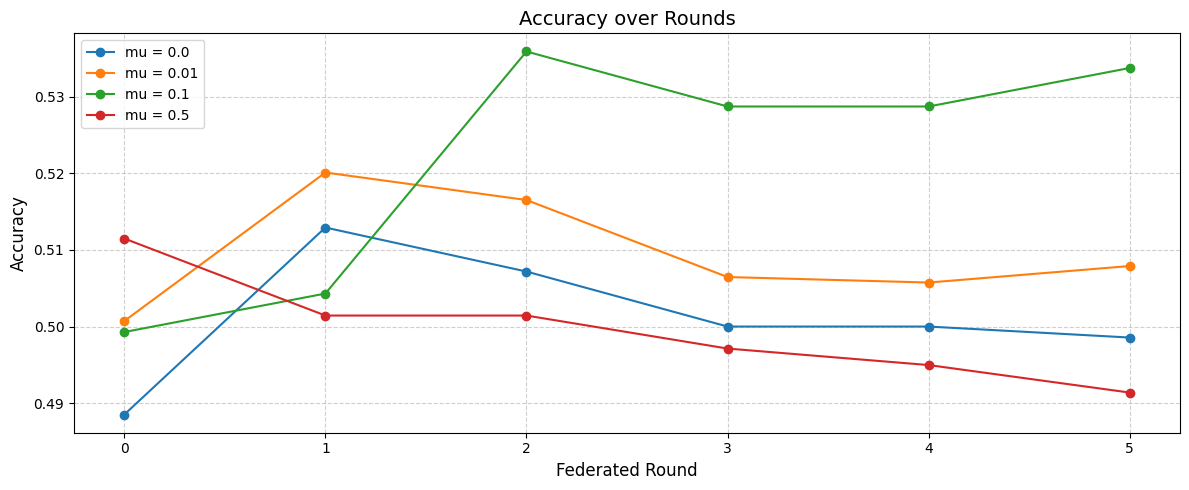

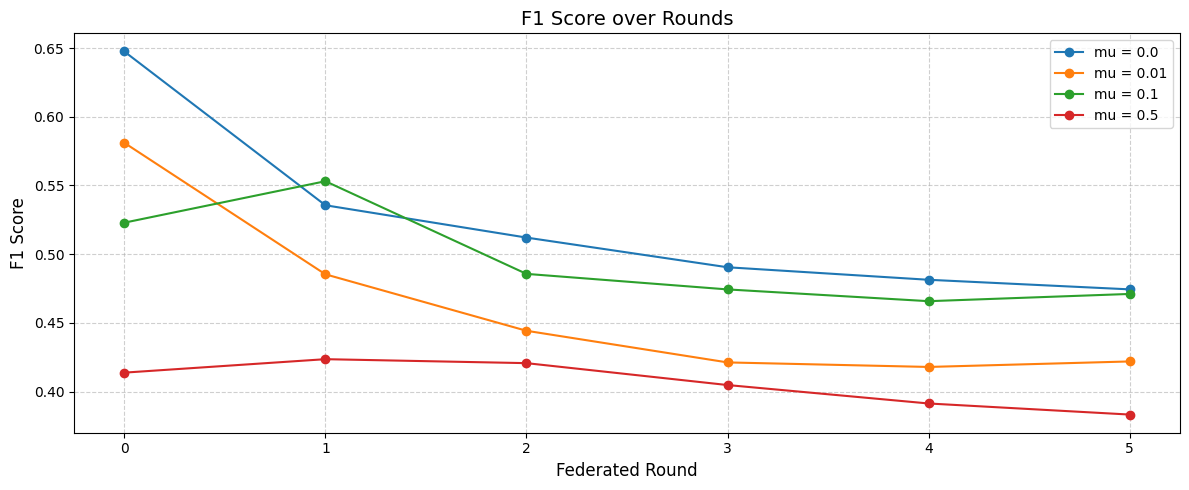

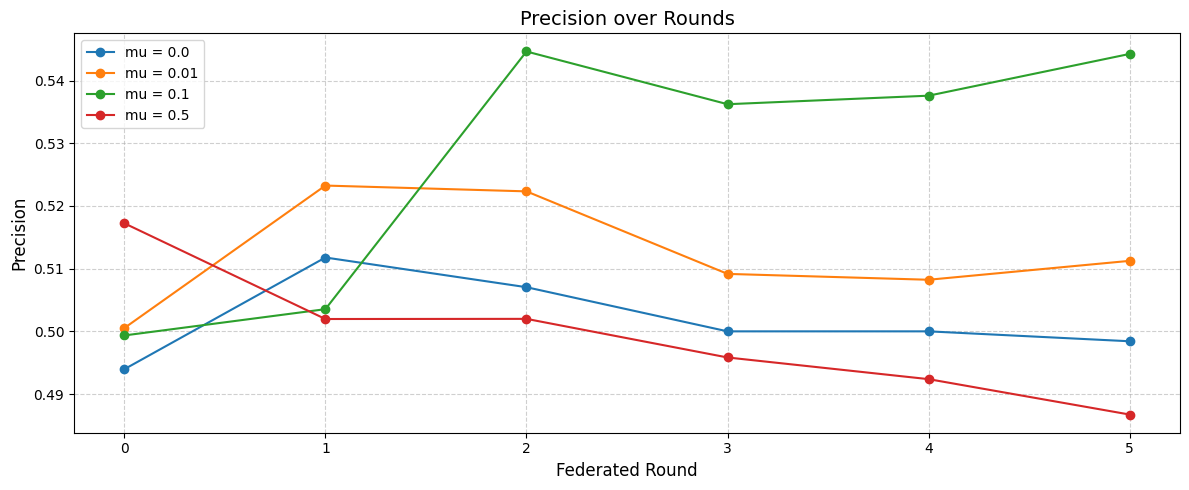

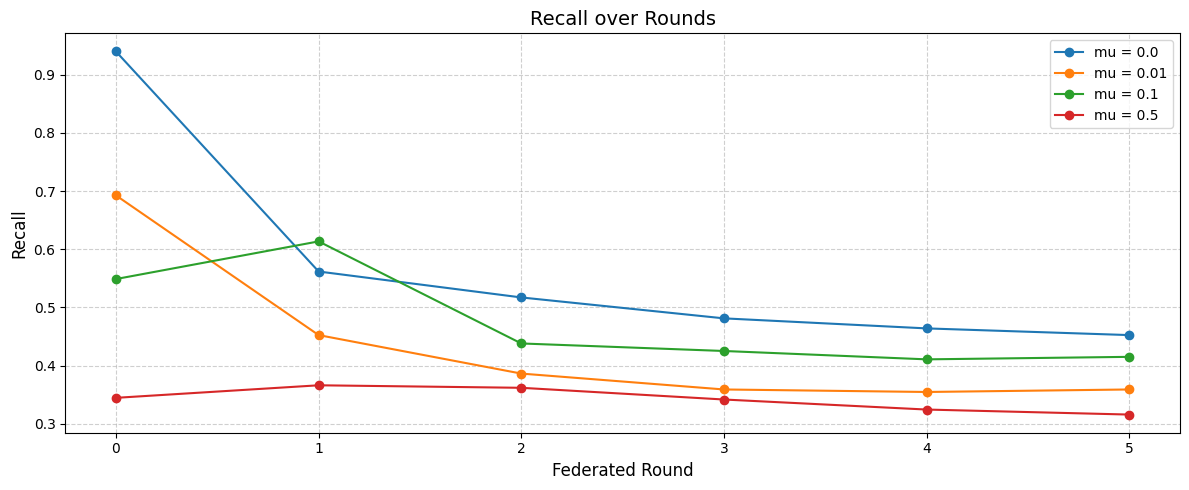

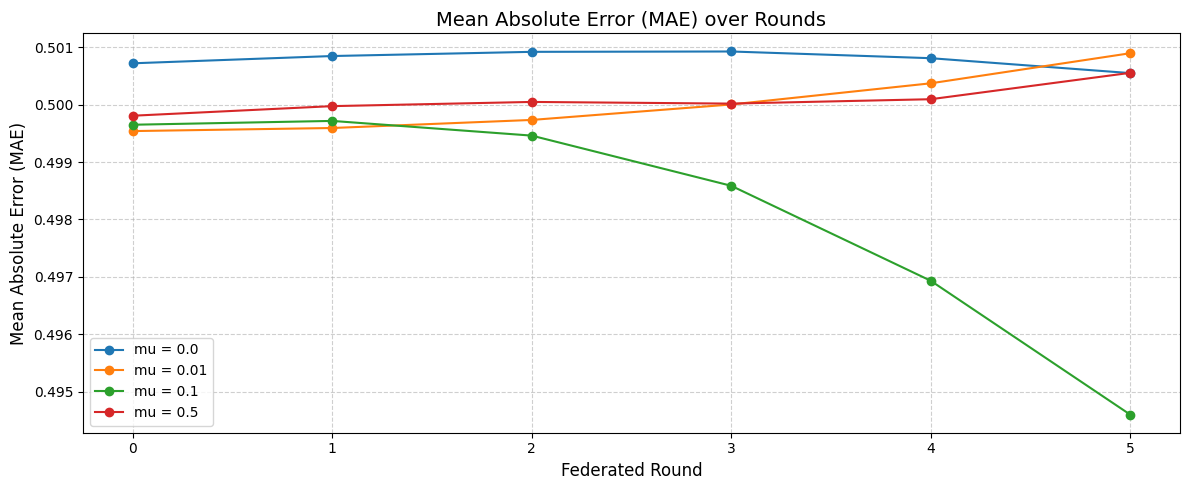

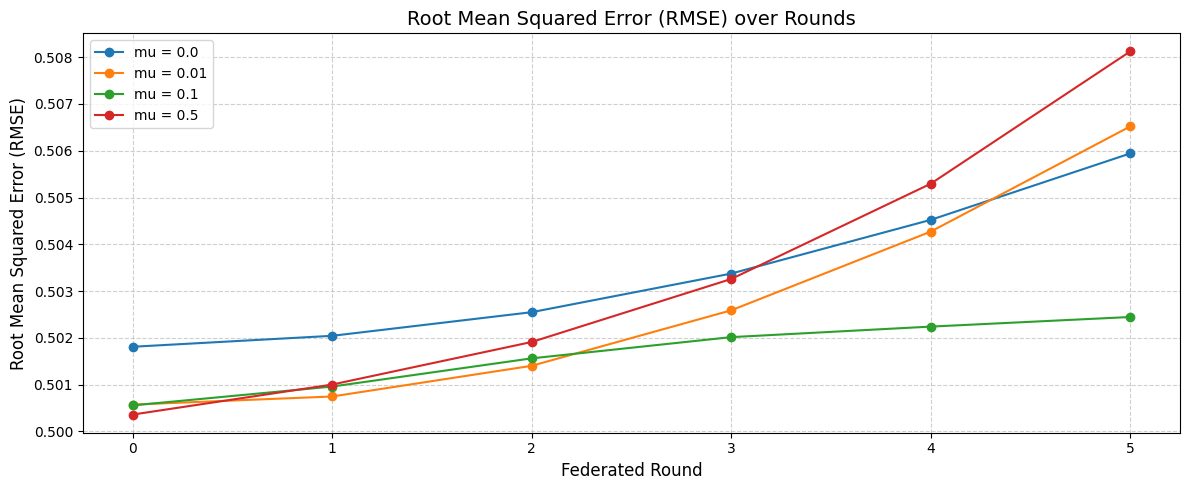

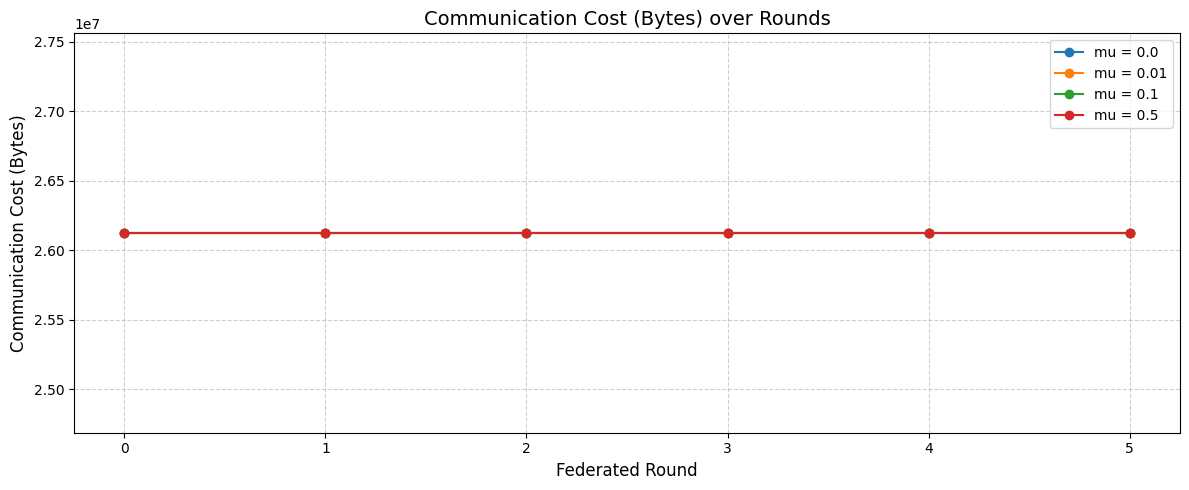

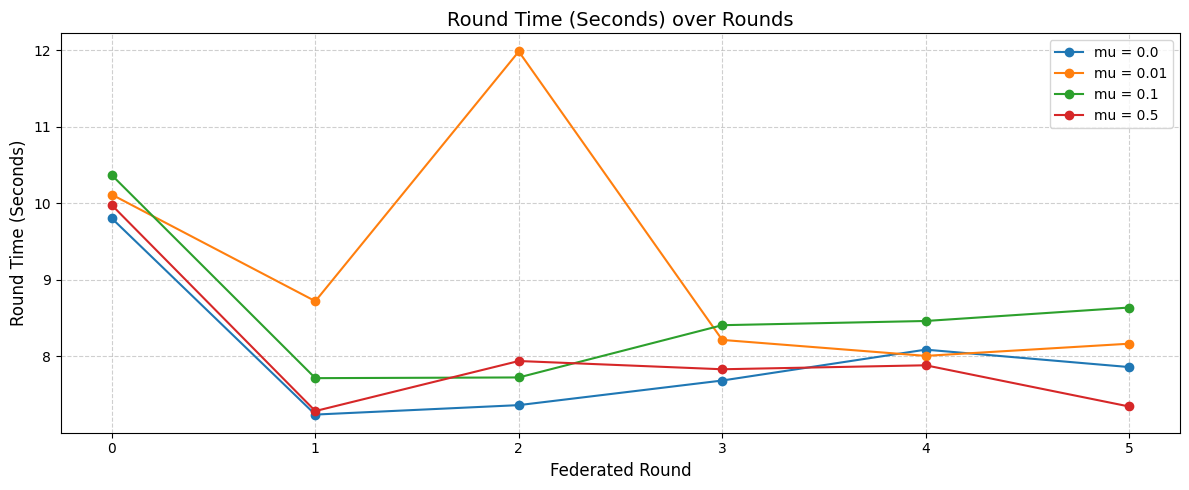

In [4]:
# --- Plotting and Saving Results ---
import matplotlib.pyplot as plt
import pandas as pd

# Liste des métriques à tracer
all_metrics = [
    "accuracy", "f1_score", "precision", "recall",
    "mae", "rmse", "comm_bytes", "round_time_sec"
]

# Titres jolis pour chaque métrique
metric_titles = {
    "accuracy": "Accuracy",
    "f1_score": "F1 Score",
    "precision": "Precision",
    "recall": "Recall",
    "mae": "Mean Absolute Error (MAE)",
    "rmse": "Root Mean Squared Error (RMSE)",
    "comm_bytes": "Communication Cost (Bytes)",
    "round_time_sec": "Round Time (Seconds)"
}

# 1. Tracer toutes les métriques et sauvegarder en PNG
for metric in all_metrics:
    plt.figure(figsize=(12, 5))
    for mu, (metrics_dict) in results.items():
        plt.plot(metrics_dict[metric], marker='o', label=f"mu = {mu}")
    plt.title(f"{metric_titles[metric]} over Rounds", fontsize=14)
    plt.xlabel("Federated Round", fontsize=12)
    plt.ylabel(metric_titles[metric], fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{metric}_fedprox_comparison.png")
    plt.show()

# 2. Exporter les résultats de chaque mu en fichier CSV
for mu, (metrics_dict) in results.items():
    df = pd.DataFrame(metrics_dict)
    df.to_csv(f"fedprox_mu_{mu}.csv", index=False)
